In [6]:
import torch
from torch import nn
import torchvision.models as models
import torchvision
from revuresnet18 import revuresnet18
import cv2
import numpy as np

In [21]:
class Model2p5d(torch.nn.Module):
    def __init__(self):
        super(Model2p5d, self).__init__()
        self.model = models.resnet18(pretrained = True)
         
        module_list = list()
        
        in_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                            bias=False)
        module_list.append(
            nn.Sequential(
                in_conv,
                self.model.bn1,
                self.model.relu,
                self.model.maxpool
            )
        )
        
        module_list.append(self.model.layer1)
        module_list.append(self.model.layer2)
        module_list.append(self.model.layer3)
        module_list.append(self.model.layer4)
        self.encoder = nn.ModuleList(module_list)
        
        
        out_planes = [3,1,1]
        layer_names = ['normal','depth','sil']
        
        self.decoders = {}
        for out_plane, layer_name in zip(out_planes, layer_names):
            module_list2 = list()
            revresnet = revuresnet18(out_planes=out_plane)
            module_list2.append(revresnet.layer1)
            module_list2.append(revresnet.layer2)
            module_list2.append(revresnet.layer3)
            module_list2.append(revresnet.layer4)
            module_list2.append(
                nn.Sequential(
                    revresnet.deconv1,
                    revresnet.bn1,
                    revresnet.relu,
                    revresnet.deconv2
                )
            )
            module_list2 = nn.ModuleList(module_list2)
            setattr(self, 'decoder_' + layer_name, module_list2)
            self.decoders[layer_name] = module_list2
        
    def forward(self,im):
        feat = im
        feat_maps = list()
        for f in self.encoder:
            feat = f(feat)
            feat_maps.append(feat)
            
        self.encoder_out = feat_maps[-1]
        
        outputs = {}
        for layer_name, decoder in self.decoders.items():
            x = feat_maps[-1]
            for idx, f in enumerate(decoder):
                x = f(x)
                if idx < len(decoder) - 1:
                    feat_map = feat_maps[-(idx + 2)]
                    assert feat_map.shape[2:4] == x.shape[2:4]
                    x = torch.cat((x, feat_map), dim=1)
            outputs[layer_name] = x
        
        return outputs


In [34]:
class Trainer():
    def __init__(self,model):
        self.model = model
        
    def preprocess_inp(self,img):
        img = cv2.resize(img, (256,256))
        transform = torchvision.transforms.ToTensor()
        img = transform(img).unsqueeze(0)
        return img
    
    def preprocess_labels(self,labels):
        
        normal = cv2.resize(labels['normal'], (256,256))
        depth = cv2.resize(labels['depth'], (256,256))
        sil = cv2.resize(labels['sil'], (256,256))
        
        transform = torchvision.transforms.ToTensor()
        normal = transform(normal).unsqueeze(0)
        
        depth = transform(depth[:,:,0]).unsqueeze(0)
        sil = transform(sil[:,:,0]).unsqueeze(0)
        
        
        labels['normal'] = normal
        labels['depth'] = depth
        labels['sil'] = sil
        
        return labels
    
        
    def train(self, model):
        
        num_epochs = 1000
        num_batch  = 1
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
        
        for epoch in range(num_epochs):
            
            for batch in range(num_batch):
                
                # Load data and labels of that batch
                
                img = cv2.imread("chair.png")
                img = self.preprocess_inp(img)                
                
                labels = {}
                labels['normal'] = cv2.imread("normal.png")
                labels['depth'] = cv2.imread("depth.png")
                labels['sil'] = cv2.imread("sil.png")
                
                labels_bat = self.preprocess_labels(labels)
                
             
                output = model.forward(img)
                
                loss_normal = criterion(output['normal'], labels_bat['normal'])
                loss_depth = criterion(output['depth'], labels_bat['depth'])
                loss_sil = criterion(output['sil'], labels_bat['sil'])

                loss = loss_normal + loss_depth + loss_sil            
            
                if epoch % 100 == 99:
                    
                    print("Epoch: ", epoch , "Loss: ", loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        return model
                

model = Model2p5d()
trainer = Trainer(model)
trained_model = trainer.train(model)
img = cv2.imread("chair.png")
img = cv2.resize(img, (256,256))
transform = torchvision.transforms.ToTensor()
img = transform(img).unsqueeze(0)
output = trained_model.forward(img)


Epoch:  99 Loss:  0.08214376866817474
Epoch:  199 Loss:  0.0374528169631958
Epoch:  299 Loss:  0.0236645620316267
Epoch:  399 Loss:  0.01700783707201481
Epoch:  499 Loss:  0.013076769188046455
Epoch:  599 Loss:  0.010441615246236324
Epoch:  699 Loss:  0.008554279804229736
Epoch:  799 Loss:  0.007142000366002321
Epoch:  899 Loss:  0.0060519324615597725
Epoch:  999 Loss:  0.005203141365200281


(256, 256)


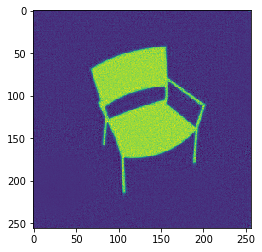

In [47]:
import matplotlib.pyplot as plt
sil = output['sil'].detach().numpy().squeeze()
print(sil.shape)
plt.imshow(sil)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


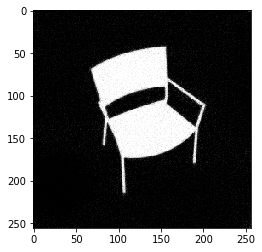

In [48]:
sil = np.resize(sil,(1,256,256))
sil = np.vstack((sil,sil,sil))
sil = sil.transpose(1,2,0)
print(sil.shape)
plt.imshow(sil)

In [41]:
from PIL import Image
import cv2
import numpy as np
img = cv2.imread("chair.png")
img = cv2.resize(img, (256,256))
transform = torchvision.transforms.ToTensor()
img = transform(img).unsqueeze(0)
train = Model2p5d()
output = train.forward(img)
print("Normal:", output['normal'].shape)
print("Depth:", output['depth'].shape)
print("Silhouette:", output['sil'].shape)



Normal: torch.Size([1, 3, 256, 256])
Depth: torch.Size([1, 1, 256, 256])
Silhouette: torch.Size([1, 1, 256, 256])
